In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from ansys.mapdl.core import launch_mapdl

In [ ]:
mapdl = launch_mapdl()

# TENSILE LOADING

In [ ]:
# Example analysis of 200 mm x 100 mm plate with center hole diameter of 45 mm and satellite holes of 30 mm at x = 50 , 150 mm

In [ ]:
mapdl.clear("NOSTART")
mapdl.prep7()
mapdl.units("SI")  # SI-International system (m, kg, s, K).

# Define a PLANE183 element type with thickness
mapdl.et(1, "PLANE183", kop3=3)
mapdl.r(1, 0.001)  # Thickness of 1 mm

# Define a material (nominal steel in SI)
mapdl.mp("EX", 1, 210e9)  # Elastic moduli in Pa (kg/(m*s**2))
mapdl.mp("DENS", 1, 7800)  # Density in kg/m3
mapdl.mp("NUXY", 1, 0.3)  # Poisson's Ratio
mapdl.emodif("ALL", "MAT", 1)

In [ ]:
# Geometry
    
# Create a rectangular area with the hole in the middle
center_hole_dia = 0.045 # Center hole diameter = 45 mm
sat_holes_dia = 0.03 # Satellite holes diameter = 30 mm
sat_holes_loc = 0.05 # Left satellite holes location at x = 50 mm along y = 50 mm axis

# Create the rectangle
rect_anum = mapdl.blc4(width = 0.2, height = 0.1) # 200 mm x 100 mm

# Create a circle in the middle of the rectangle
circ_anum = mapdl.cyl4(0.1, 0.05, center_hole_dia/2)
    
# Create a satellite circle at locations x = 50 mm along y = 50 mm axis
sat_circ_anum = mapdl.cyl4(sat_holes_loc ,0.05, sat_holes_dia/2)
sat_circ_anum2 = mapdl.cyl4(0.2-sat_holes_loc ,0.05, sat_holes_dia/2) # (200 mm - left hole location) = right hole location

# Cut the circle out of the rectangle.
area1= mapdl.asba(rect_anum, circ_anum)
area2 = mapdl.asba(area1, sat_circ_anum)
plate_with_hole_anum = mapdl.asba(area2, sat_circ_anum2)

In [ ]:
mapdl.lplot(cpos="xy", line_width=3, font_size=26, color_lines=True, background="w")

In [ ]:
# Meshing

# Mesh the plate using a higher density near the hole and a lower density for the remainder of the plate
    
mapdl.aclear("all")
  
# Ensure there are at least 100 elements around the hole
hole_esize = np.pi * center_hole_dia / 100 
sat_hole_esize = np.pi * sat_holes_dia / 100 
plate_esize = 0.01
    
# Increased the density of the mesh at the center
mapdl.lsel("S", "LINE", vmin=5, vmax=8) # center hole
mapdl.lesize("ALL", hole_esize, kforc=1)
mapdl.lsel("S", "LINE", vmin=9, vmax=40) # satellite holes
mapdl.lesize("ALL", sat_hole_esize, kforc=1)
mapdl.lsel("ALL")

mapdl.esize(plate_esize)
mapdl.amesh(plate_with_hole_anum)
mapdl.mesh

In [ ]:
mapdl.eplot(vtk=True,cpos="xy",show_edges=True,show_axes=False,line_width=2,background="w",)

In [ ]:
# Fix the left-hand side of the plate in the X direction
mapdl.nsel("S", "LOC", "X", 0)
mapdl.d("ALL", "UX")

# Fix a single node on the left-hand side of the plate in the Y direction
mapdl.nsel("R", "LOC", "Y", 0.1 / 2)
assert mapdl.mesh.n_node == 1
mapdl.d("ALL", "UY")

# Apply a force on the right-hand side of the plate.

# Select the right-hand side of the plate.
mapdl.nsel("S", "LOC", "X", 0.2)

# Couple the DOF for these nodes
mapdl.cp(5, "UX", "ALL")

# Select a single node in this set and apply a force to it
mapdl.nsel("r", "loc", "y", 0.1 / 2)
mapdl.f("ALL", "FX", 1000) # Apply force of 1000 N

# Be sure to select all nodes again to solve the entire solution
mapdl.allsel()

In [ ]:
# Solve the Static Problem

mapdl.run("/SOLU")
mapdl.antype("STATIC")
output=mapdl.solve()
print(output)

In [ ]:
# Post-Processing

# Grab the stress from the result
result = mapdl.result
nnum, stress = result.principal_nodal_stress(0)
von_mises = stress[:, -1]
max_stress = np.nanmax(von_mises)

result.plot_principal_nodal_stress(0,"SEQV",lighting=False,cpos="xy",background="w",text_color="k",add_text=False,)

In [ ]:
# Compare to the "far field" stress by getting the mean value of the stress at the wall
mask = result.mesh.nodes[:, 0] == 0.2
far_field_stress = np.nanmean(von_mises[mask])

# Adjust by the cross sectional area at the hole
adj = 0.1 / (0.1 - 0.045) # 100 mm plate length, 45 mm center hole diameter
stress_adj = far_field_stress * adj
stress_concentration = max_stress / stress_adj

In [ ]:
print(f'Far field stress = {far_field_stress/1000000:.2f} MPa')
print(f'Maximum stress = {max_stress/1000000:.2f} MPa')
print(f'Stress concentration factor= {stress_concentration:.4f}')

In [ ]:
# Create a function to compute the stress concentration for any 2D plate with a fixed center hole and loaded with an axial force
# With two symmetric satellite holes with various sizes and locations along y = 50 mm axis
# Including the increasing of mesh density around the holes to reach convergence of the stress concentration value < 1 percents

In [ ]:
def compute_stress_con(sat_holes_dia,sat_holes_loc):
    
    converge = 1
    iteration = 1
    stress_concentration = 1
    
    while converge >= 0.01: # less than 1 percent of the stress concentration convergence is needed
        mapdl.clear("NOSTART")
        mapdl.prep7()
        mapdl.units("SI")  # SI-International system (m, kg, s, K).

        # Define a PLANE183 element type with thickness
        mapdl.et(1, "PLANE183", kop3=3)
        mapdl.r(1, 0.001)  # Thickness of 1 mm

        # Define a material (nominal steel in SI)
        mapdl.mp("EX", 1, 210e9)  # Elastic moduli in Pa (kg/(m*s**2))
        mapdl.mp("DENS", 1, 7800)  # Density in kg/m3
        mapdl.mp("NUXY", 1, 0.3)  # Poisson's Ratio
        mapdl.emodif("ALL", "MAT", 1)

        # Geometry
    
        # Create a rectangular area with the hole in the middle
        center_hole_dia = 0.045 # center hole diameter = 45 mm
    
        # Create the rectangle
        rect_anum = mapdl.blc4(width = 0.2, height = 0.1) # 200 mm x 100 mm

        # Create a circle in the middle of the rectangle
        circ_anum = mapdl.cyl4(0.1, 0.05, center_hole_dia/2)
    
        # Create a satellite circle at certain locations along y = 50 mm axis
        sat_circ_anum = mapdl.cyl4(sat_holes_loc ,0.05, sat_holes_dia/2)
        sat_circ_anum2 = mapdl.cyl4(0.2-sat_holes_loc ,0.05, sat_holes_dia/2) # 200 mm - left hole location = right hole location

        # Cut the circle out of the rectangle.
        area1= mapdl.asba(rect_anum, circ_anum)
        area2 = mapdl.asba(area1, sat_circ_anum)
        plate_with_hole_anum = mapdl.asba(area2, sat_circ_anum2)   
    
        # Meshing

        # Mesh the plate using a higher density near the hole and a lower density for the remainder of the plate
    
        mapdl.aclear("all")
  
        # Ensure there are at least 100 elements around the hole at beginning then increase 50 elements per iteration
        hole_esize = np.pi * center_hole_dia / ((iteration*50)+50) 
        sat_hole_esize = np.pi * sat_holes_dia / ((iteration*50)+50)  
        plate_esize = 0.01
    
        # Increased the density of the mesh at the center
        mapdl.lsel("S", "LINE", vmin=5, vmax=8) # center hole
        mapdl.lesize("ALL", hole_esize, kforc=1)
        mapdl.lsel("S", "LINE", vmin=9, vmax=40) # satellite holes
        mapdl.lesize("ALL", sat_hole_esize, kforc=1)
        mapdl.lsel("ALL")

        mapdl.esize(plate_esize)
        mapdl.amesh(plate_with_hole_anum)

        # Boundary Conditions

        # Fix the left-hand side of the plate in the X direction
        mapdl.nsel("S", "LOC", "X", 0)
        mapdl.d("ALL", "UX")

        # Fix a single node on the left-hand side of the plate in the Y direction
        mapdl.nsel("R", "LOC", "Y", 0.1 / 2)
        assert mapdl.mesh.n_node == 1
        mapdl.d("ALL", "UY")

        # Apply a force on the right-hand side of the plate.
        
        # Select the right-hand side of the plate.
        mapdl.nsel("S", "LOC", "X", 0.2)

        # Couple the DOF for these nodes
        mapdl.cp(5, "UX", "ALL")

        # Select a single node in this set and apply a force to it
        mapdl.nsel("r", "loc", "y", 0.1 / 2)
        mapdl.f("ALL", "FX", 1000)

        # Be sure to select all nodes again to solve the entire solution
        mapdl.allsel()

        # Solve the Static Problem

        mapdl.run("/SOLU")
        mapdl.antype("STATIC")
        mapdl.solve()

        # Post-Processing

        # Grab the stress from the result
        result = mapdl.result
        nnum, stress = result.principal_nodal_stress(0)
        von_mises = stress[:, -1]
        max_stress = np.nanmax(von_mises)

        # Compare to the "far field" stress by getting the mean value of the stress at the wall
        mask = result.mesh.nodes[:, 0] == 0.2
        far_field_stress = np.nanmean(von_mises[mask])

        # Adjust by the cross sectional area at the hole
        adj = 0.1 / (0.1 - 0.045) # 100 mm plate length, 45 mm center hole diameter
        stress_adj = far_field_stress * adj
        
        converge = abs(stress_concentration - (max_stress / stress_adj))/stress_concentration
        
        stress_concentration = max_stress / stress_adj
        
        iteration +=1
        
    return stress_concentration,iteration-1, converge

In [ ]:
Sat_hole_dia=[i for i in range (4,41,2)] # diameter of satellite holes start from 4 to 40 mm with 2 mm increasing step

List=[]

for hole_dia in Sat_hole_dia:
    location = 100
    # Margin = distance from left wall to left radius of the left satellite hole
    # Margin should finally located between 0.005 to 0.076 (x = 5 mm to 76 mm) 
    # The left outer radius of center hole is locate at 77.5 mm
    # Satellite holes should located atleast out of center holes radius but not too far to the edge of plate)
    
    while location-(hole_dia/2)>76:
        location -= 1

    while location-(hole_dia/2)>=5:
        if 0 < 77.5-(location+(hole_dia/2)) < 2: # Check if the distance between satellite and center hole is less than 2 mm ?
            # If the right outer radius of the left satellite hole is too close to the center hole, skip this location
            location -= 1
        else:
            List.append([hole_dia/1000,location/1000]) # Satellite holes sizes and locations for iterations
            location -= 1

In [ ]:
len(List)

In [ ]:
Kt_tension=[]
Number_of_iter=[]
i=1
for size,loc in List:
    a,b,c=compute_stress_con(size,loc)
    Kt_tension.append(a)
    Number_of_iter.append([b,c])
    print(f'finished {i}/{len(List)} simulation ...')
    i+=1  

In [ ]:
np.savetxt("List.csv", List,delimiter =", ", fmt ='% s')

In [ ]:
np.savetxt("Kt_tension.csv", Kt_tension, delimiter =", ", fmt ='% s')
np.savetxt("Number_of_iter.csv", Number_of_iter, delimiter =", ", fmt ='% s')

# BENDING LOADING

In [ ]:
mapdl.clear("NOSTART")
mapdl.prep7()
mapdl.units("SI")  # SI-International system (m, kg, s, K).

mapdl.et(1, "SOLID186")

# Define a material (nominal steel in SI)
mapdl.mp("EX", 1, 210e9)  # Elastic moduli in Pa (kg/(m*s**2))
mapdl.mp("DENS", 1, 7800)  # Density in kg/m3
mapdl.mp("NUXY", 1, 0.3)  # Poisson's Ratio
mapdl.emodif("ALL", "MAT", 1)

In [ ]:
def compute_stress_con(sat_holes_dia,sat_holes_loc):
    
    mapdl.clear("NOSTART")
    mapdl.prep7()
    mapdl.units("SI")  # SI-International system (m, kg, s, K).

    mapdl.et(1, "SOLID186")
    # Define a material (nominal steel in SI)
    mapdl.mp("EX", 1, 210e9)  # Elastic moduli in Pa (kg/(m*s**2))
    mapdl.mp("DENS", 1, 7800)  # Density in kg/m3
    mapdl.mp("NUXY", 1, 0.3)  # Poisson's Ratio
    mapdl.emodif("ALL", "MAT", 1)

    # Geometry
    
    # Create a rectangular area with the hole in the middle
    center_hole_dia = 0.045 # Center hole diameter = 45 mm

    # Create the rectangle
    rect_anum = mapdl.blc4(width = 0.2, height = 0.1) # 200 mm x 100 mm

    # Create a circle in the middle of the rectangle
    circ_anum = mapdl.cyl4(0.1, 0.05, center_hole_dia/2)
    
    # Create a satellite circle at locations x = 50 mm along y = 50 mm axis
    sat_circ_anum = mapdl.cyl4(sat_holes_loc ,0.05, sat_holes_dia/2)
    sat_circ_anum2 = mapdl.cyl4(0.2-sat_holes_loc ,0.05, sat_holes_dia/2) # (200 mm - left hole location) = right hole location

    # Cut the circle out of the rectangle.
    area1= mapdl.asba(rect_anum, circ_anum)
    area2 = mapdl.asba(area1, sat_circ_anum)
    plate_with_hole_area = mapdl.asba(area2, sat_circ_anum2)
    plate_with_hole_anum=mapdl.vext(plate_with_hole_area, dz=0.003) # make volume from area (thickness = 3 mm)
    
    # Meshing

    mapdl.lesize("ALL", 0.005, layer1=1)

    mapdl.mshape(1, "3D")
    mapdl.mshkey(0)

    mapdl.vmesh('all')

    # Boundary Conditions

    mapdl.nsel('s','loc','x',0)
    mapdl.d('all','all',0)

    mapdl.nsel('S','LOC','X', 0.2)
    mapdl.nsel("R", "LOC", "Y", 0.1/2)
    single_node = mapdl.mesh.nnum[0]
    mapdl.nsel("S", "NODE", vmin=single_node, vmax=single_node)
    mapdl.f("ALL", "FZ", -100)

    mapdl.allsel()
    mapdl.finish()

    # Solve the Static Problem

    mapdl.run("/SOLU")
    mapdl.antype("STATIC")
    mapdl.solve()

    # Post-Processing

    # Grab the stress from the result
    result = mapdl.result
    nnum, stress = result.principal_nodal_stress(0)
    
    stress_left_hole = mapdl.get('sigeqv', 'node','node(sat_holes_loc,0.05+(sat_holes_dia/2),0)','s','eqv')
    stress_center_hole = mapdl.get('sigeqv', 'node','node(0.1,0.05+0.045/2,0)','s','eqv')
    
    nominal_stress_left = 6*(100)*(0.2-sat_holes_loc)/((0.1-sat_holes_dia)*(0.003**2))
    nominal_stress_center = 6*(100)*(0.1)/((0.1-0.045)*(0.003**2))
    
    KT_left = stress_left_hole / nominal_stress_left
    KT_center = stress_center_hole / nominal_stress_center
        
    return sat_holes_dia,sat_holes_loc,KT_left,KT_center

In [ ]:
Sat_hole_dia=[i for i in range (4,41,2)] # diameter of satellite holes start from 4 to 40 mm with 2 mm increasing step

List=[]

for hole_dia in Sat_hole_dia:
    location = 100
    # Margin = distance from left wall to left radius of the left satellite hole
    # Margin should finally located between 0.005 to 0.076 (x = 5 mm to 76 mm) 
    # The left outer radius of center hole is locate at 77.5 mm
    # Satellite holes should located atleast out of center holes radius but not too far to the edge of plate)
    
    while location-(hole_dia/2)>76:
        location -= 1

    while location-(hole_dia/2)>=5:
        if 0 < 77.5-(location+(hole_dia/2)) < 2: # Check if the distance between satellite and center hole is less than 2 mm ?
            # If the right outer radius of the left satellite hole is too close to the center hole, skip this location
            location -= 1
        else:
            List.append([hole_dia/1000,location/1000]) # Satellite holes sizes and locations for iterations
            location -= 1

In [ ]:
Bending=[]
i=1
for size,loc in List:
    a,b,c,d=compute_stress_con(size,loc)
    Bending.append([a,b,c,d])
    print(f'finished {i}/{len(List)} simulation ...')
    i+=1  

In [ ]:
np.savetxt("Bending.csv", Bending,delimiter =", ", fmt ='% s')

# Graph Plot

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import re, seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

In [2]:
df=pd.read_csv('KT.csv') # File has been modified from tensile and bending simulation results
df

,Sat_D,Sat_Loc,KTT,KTB
0,4,22,2.265740,1.162669
1,4,23,2.273066,1.150641
2,4,24,2.282458,1.181710
3,4,27,2.236672,1.157641
4,4,28,2.227778,1.162678
...,...,...,...,...
1325,40,71,1.781534,1.176948
1326,40,72,1.797661,1.179423
1327,40,73,1.816999,1.178393
1328,40,74,1.837149,1.183254


In [3]:
x=df['Sat_Loc']
y=df['Sat_D']
z=df['KTT']
z2=df['KTB']

In [4]:
zk=[]
for i in range(len(z2)):
    if z2[i]<1.132:
        zk.append(z2[i]+0.02)
    else:
        zk.append(z2[i])
zz=[]
for j in range(1330):
    if zk[j]<1.138:
        zz.append(zk[j]+0.013)
    else:
        zz.append(zk[j])

In [5]:
dfT=df.drop(['KTB'],axis=1)
dfB=df.drop(['KTT'],axis=1)

<IPython.core.display.Javascript object>


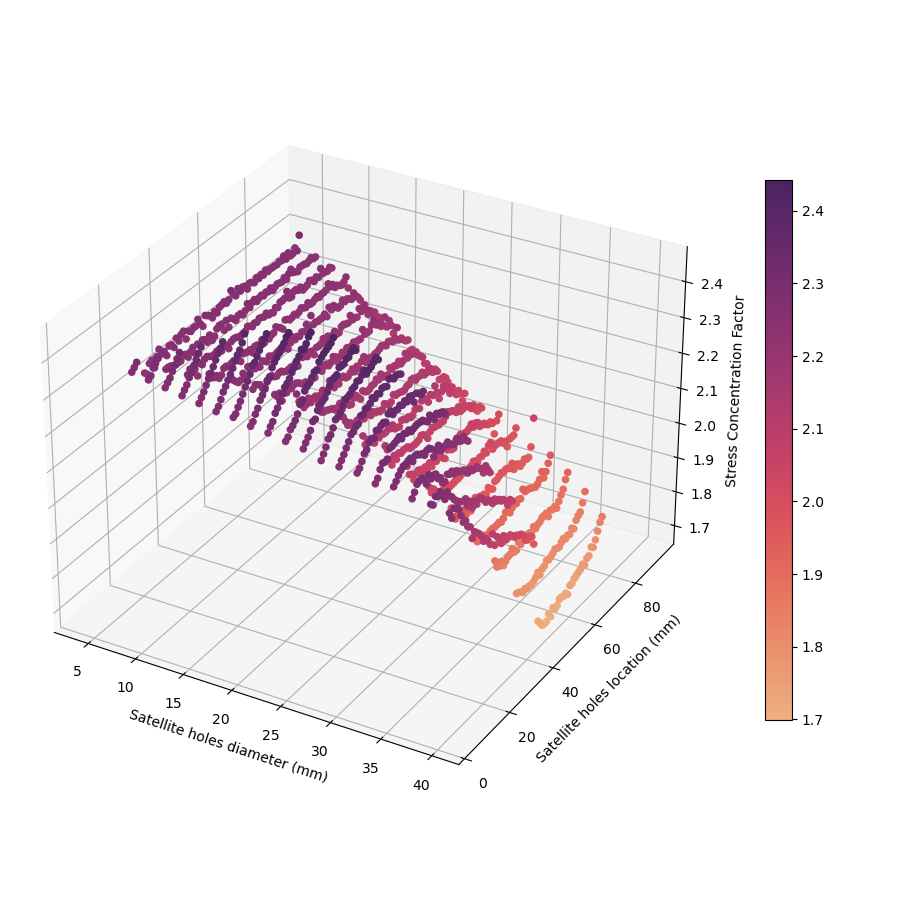

In [6]:
%matplotlib notebook
fig = plt.figure(figsize=(9,9))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn


# plot
sc = ax.scatter(y, x, z, s=20, c=z, marker='o', cmap=sns.color_palette("flare", as_cmap=True), alpha=1)
ax.set_zlabel('Stress Concentration Factor')
ax.set_ylabel('Satellite holes location (mm)')
ax.set_xlabel('Satellite holes diameter (mm)')
plt.colorbar(sc, shrink=0.6)

# legend
#plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

<IPython.core.display.Javascript object>


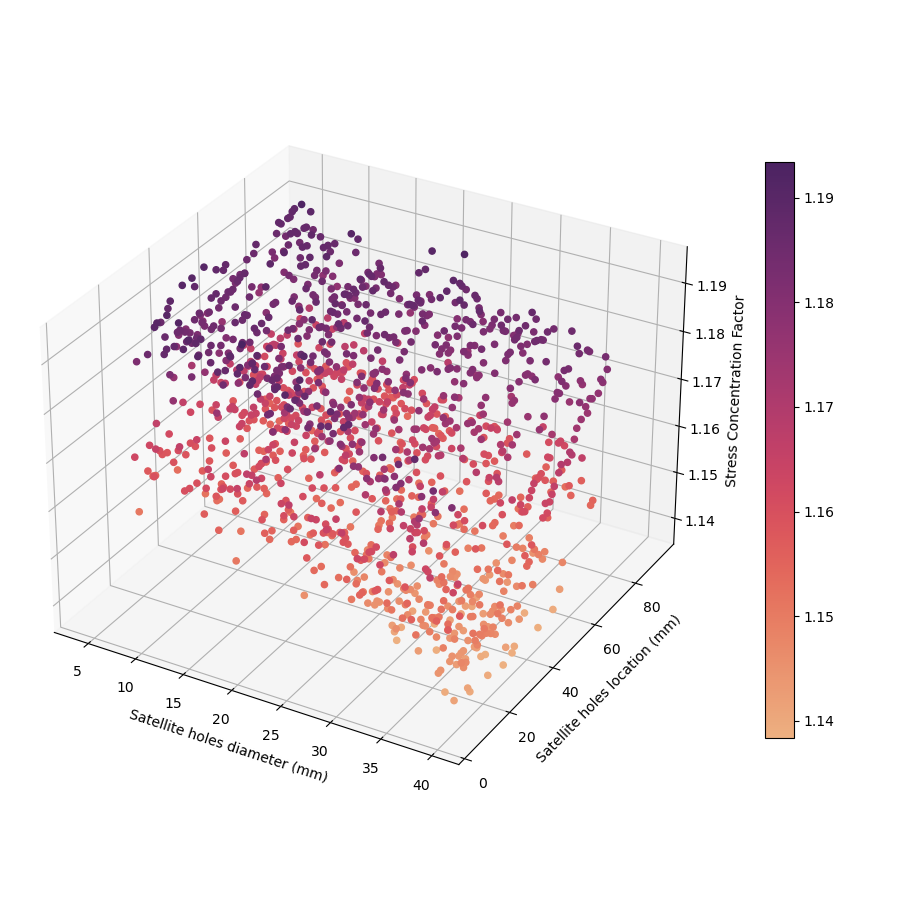

In [7]:
%matplotlib notebook
fig = plt.figure(figsize=(9,9))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn


# plot
sc = ax.scatter(y, x, zz, s=20, c=zz, marker='o', cmap=sns.color_palette("flare", as_cmap=True), alpha=1)
ax.set_zlabel('Stress Concentration Factor')
ax.set_ylabel('Satellite holes location (mm)')
ax.set_xlabel('Satellite holes diameter (mm)')
plt.colorbar(sc, shrink=0.64)

# legend
#plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')